## Assignment 7 - Part A
- Student UW NetID : vaibhavi@uw.edu
- Student Name     : Vaibhavi Rangarajan
---

###  Import Libraries

In [2]:
import re
from time import time
import string
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from pprint import pprint

#Sklearn Imports
from sklearn import metrics
from sklearn.datasets import fetch_20newsgroups
from sklearn import preprocessing
from sklearn.pipeline import Pipeline
from sklearn.feature_extraction.text import TfidfVectorizer, TfidfTransformer
from sklearn.naive_bayes import MultinomialNB
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import confusion_matrix, precision_recall_curve, roc_auc_score, auc

from nltk import PorterStemmer
from nltk.corpus import stopwords
from nltk.tokenize import sent_tokenize, word_tokenize

import nltk
nltk.download('stopwords') #download the latest stopwords

[nltk_data] Downloading package stopwords to
[nltk_data]     /Users/shrawan/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


True

### Load Dataset

In [3]:
all_newsgroups= fetch_20newsgroups()

In [4]:
pprint(list(all_newsgroups.target_names))

['alt.atheism',
 'comp.graphics',
 'comp.os.ms-windows.misc',
 'comp.sys.ibm.pc.hardware',
 'comp.sys.mac.hardware',
 'comp.windows.x',
 'misc.forsale',
 'rec.autos',
 'rec.motorcycles',
 'rec.sport.baseball',
 'rec.sport.hockey',
 'sci.crypt',
 'sci.electronics',
 'sci.med',
 'sci.space',
 'soc.religion.christian',
 'talk.politics.guns',
 'talk.politics.mideast',
 'talk.politics.misc',
 'talk.religion.misc']


#### Create Train and Test Data  [from categories-medical and automobiles]

In [5]:
cats = ['sci.med' , 'rec.motorcycles']
newsgroups_train = fetch_20newsgroups(subset='train', categories=cats, remove=('headers', 'footers', 'quotes'))
newsgroups_test = fetch_20newsgroups(subset='test', categories=cats, remove=('headers', 'footers', 'quotes'))

In [6]:
print("Categories to classify\n-----------------------")
print(list(newsgroups_train.target_names))

Categories to classify
-----------------------
['rec.motorcycles', 'sci.med']


In [7]:
print("TRAIN DATA\n---------------")
print("Data Type:", type(newsgroups_train))
print("%d documents" % len(newsgroups_train.filenames))
print("%d categories" % len(newsgroups_train.target_names))
print("X shape :", newsgroups_train.filenames.shape)
print("Y shape :",newsgroups_train.target.shape)
print("Y head  :", newsgroups_train.target[:10])

TRAIN DATA
---------------
Data Type: <class 'sklearn.datasets.base.Bunch'>
1192 documents
2 categories
X shape : (1192,)
Y shape : (1192,)
Y head  : [1 0 0 1 1 1 0 0 1 1]


In [8]:
print("TEST DATA\n---------------")
print("Data Type:", type(newsgroups_test))
print("%d documents" % len(newsgroups_test.filenames))
print("%d categories" % len(newsgroups_test.target_names))
print("X shape :", newsgroups_test.filenames.shape)
print("Y shape :",newsgroups_test.target.shape)
print("Y head  :", newsgroups_test.target[:10])

TEST DATA
---------------
Data Type: <class 'sklearn.datasets.base.Bunch'>
794 documents
2 categories
X shape : (794,)
Y shape : (794,)
Y head  : [0 0 0 0 1 0 1 0 1 1]


### Explore the data

In [9]:
print(newsgroups_train.data[0])

=I think that's the correct spelling..
=	I am looking for any information/supplies that will allow
=do-it-yourselfers to take Krillean Pictures. I'm thinking
=that education suppliers for schools might have a appartus for
=sale, but I don't know any of the companies. Any info is greatly
=appreciated.
=	In case you don't know, Krillean Photography, to the best of my
=knowledge, involves taking pictures of an (most of the time) organic
=object between charged plates. The picture will show energy patterns
=or spikes around the object photographed, and depending on what type
=of object it is, the spikes or energy patterns will vary. One might
=extrapolate here and say that this proves that every object within
=the universe (as we know it) has its own energy signature.

Go to the library and look up "corona discharge."
--------------------------------------------------------------------------------
Carl J Lydick | INTERnet: CARL@SOL1.GPS.CALTECH.EDU | NSI/HEPnet: SOL1::CARL


In [10]:
print(newsgroups_test.data[0])


you may have been able to bounce the front up but not
actually do a "wheelie". see the shaft effect unloads
the rear susspension and effectivly loads the front.
this is why a shaft bike should accelerate if it starts
scraping in a corner......



In [11]:
print(type(newsgroups_test.data))
print(type(newsgroups_test.data[0]))

<class 'list'>
<class 'str'>


### Pre-process Data

In [12]:
train_labels = newsgroups_train.target #0, 1 array
#print(train_labels)

test_labels = newsgroups_test.target
#print(test_labels)

RE_PREPROCESS = r'\W+|\d+' #the regular expressions that matches all non-characters
#train_corpus = np.array( [re.sub(RE_PREPROCESS, ' ', text).lower() for text in df_train.jobDescription.values])
#test_corpus = np.array( [re.sub(RE_PREPROCESS, ' ', text).lower() for text in df_test.jobDescription.values])

labels = np.append(train_labels, test_labels)

###  Transform Data (Vectorize)

In [13]:
vectorizer = TfidfVectorizer()
vectors_train = vectorizer.fit_transform(newsgroups_train.data)
vectors_train.shape

(1192, 18044)

In [14]:
vectors_train.nnz / float(vectors_train.shape[0])

87.37835570469798

In [15]:
vectors_test = vectorizer.transform(newsgroups_test.data)

There are 18000+ features for each document. And on average, 87 out of 18000 features are non-zeros. This is a sparse matrix

### Train Classifier

In [16]:
clf = MultinomialNB(alpha=.01)
clf.fit(vectors_train, newsgroups_train.target)

MultinomialNB(alpha=0.01, class_prior=None, fit_prior=True)

### Evaluate Classifier

In [17]:
y_true = newsgroups_test.target
y_pred = clf.predict(vectors_test)

In [18]:
metrics.f1_score(y_true, y_pred, average='macro')

0.94202097937620644

**Interpretation:**  An F-1 score of 0.94 is high. Our model is performant.

### Plot Confusion Matrix

In [19]:
cm = confusion_matrix(y_true, y_pred)

#### Pretty Print Confusion Matrix

In [20]:
def print_cm(cm, labels, hide_zeroes=False, hide_diagonal=False, hide_threshold=None):
    """pretty print for confusion matrixes"""
    columnwidth = max([len(x) for x in labels] + [5])  # 5 is value length
    empty_cell = " " * columnwidth
    # Print header
    print("    " + empty_cell, end=" ")
    for label in labels:
        print("%{0}s".format(columnwidth) % label, end=" ")
    print()
    
    # Print rows
    for i, label1 in enumerate(labels):
        print("    %{0}s".format(columnwidth) % label1, end=" ")
        for j in range(len(labels)):
            cell = "%{0}.1f".format(columnwidth) % cm[i, j]
            if hide_zeroes:
                cell = cell if float(cm[i, j]) != 0 else empty_cell
            if hide_diagonal:
                cell = cell if i != j else empty_cell
            if hide_threshold:
                cell = cell if cm[i, j] > hide_threshold else empty_cell
            print(cell, end=" ")
        print()

print_cm(cm, labels = ['Automobiles', 'Medical'])

                Automobiles     Medical 
    Automobiles       385.0        13.0 
        Medical        33.0       363.0 


In [21]:
pd.crosstab(y_true, y_pred, rownames=['True'], colnames=['Predicted'], margins=True)

Predicted,0,1,All
True,,,
0,385,13,398
1,33,363,396
All,418,376,794


**Interpretation:**

- From 398 Automobile related articles, we classifier 385 Correctly.
- From 396 Medicine related articles, we classified, 363 Correctly.

### Plot: Precision-Recall Curve

In [22]:
def plot_precision_recall(y_true,y_score):
    """
    Plot a precision recall curve
    
    Parameters
    ----------
    y_true: ls
        ground truth labels
    y_score: ls
        score output from model
    """
    precision_curve, recall_curve, pr_thresholds = precision_recall_curve(y_true,y_score[:,1])
    plt.plot(recall_curve, precision_curve)
    plt.xlabel('Recall')
    plt.ylabel('Precision')
    auc_val = auc(recall_curve,precision_curve)
    print('AUC-PR: {0:1f}'.format(auc_val))
    plt.show()
    plt.clf()

AUC-PR: 0.989524


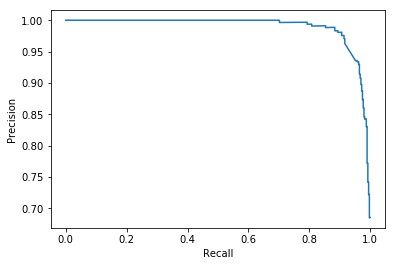

In [23]:
y_score = clf.predict_proba(vectors_test)
plot_precision_recall(y_true, y_score)

**Interpretation:**
The area under the curve is 0.98, just shy of the ideal 1.0.
The trained classifier is extending to the test set well.

---

### Improve:  Grid Search CV for Classifier

Let's play with parameters for the TFIDF Vectorizer, and Alpha (Laplace smoothing) for the Naive Bayes Classifier

- http://scikit-learn.org/stable/modules/generated/sklearn.feature_extraction.text.TfidfVectorizer.html
- http://scikit-learn.org/stable/modules/generated/sklearn.naive_bayes.MultinomialNB.html



In [24]:
#Params - NOT tuned
ANALYZER = "word" #unit of features are single words rather then phrases of words 
STRIP_ACCENTS = 'unicode'
TOKENIZER = None
MAX_DF = (1.0)  # Exclude words that have a frequency greater than the threshold 
STOP_WORDS = (stopwords.words('english'), None)


#Params - TUNED
NGRAM_RANGE = ((0,1), (0,2)) #Range for pharases of words
MIN_DF = (0, 0.01) # Exclude words that have a frequency less than the threshold
ALPHA = (0.01, 0.1, 1)


In [25]:
pipeline = Pipeline([('tfidf', TfidfVectorizer()), ('clf', MultinomialNB())])

# uncommenting more parameters will give better exploring power but will
# increase processing time in a combinatorial way
parameters = {
    'tfidf__ngram_range':NGRAM_RANGE,
    'tfidf__min_df':MIN_DF,
    'clf__alpha': ALPHA,
}

In [26]:
def optimize_pipeline(pipeline):
    # multiprocessing requires the fork to happen in a __main__ protected
    # block

    # find the best parameters for both the feature extraction and the
    # classifier
    grid_search = GridSearchCV(pipeline, parameters, n_jobs=-1, verbose=True)

    print("Performing grid search...")
    print("pipeline:", [name for name, _ in pipeline.steps])
    print("parameters:")
    pprint(parameters)
    t0 = time()
    grid_search.fit(newsgroups_train.data, newsgroups_train.target)
    print("done in %0.3fs" % (time() - t0))
    print()

    print("Best score: %0.3f" % grid_search.best_score_)
    print("Best parameters set:")
    best_parameters = grid_search.best_estimator_.get_params()
    for param_name in sorted(parameters.keys()):
        print("\t%s: %r" % (param_name, best_parameters[param_name]))


In [27]:
optimize_pipeline(pipeline)

Performing grid search...
pipeline: ['tfidf', 'clf']
parameters:
{'clf__alpha': (0.01, 0.1, 1),
 'tfidf__min_df': (0, 0.01),
 'tfidf__ngram_range': ((0, 1), (0, 2))}
Fitting 3 folds for each of 12 candidates, totalling 36 fits


[Parallel(n_jobs=-1)]: Done  36 out of  36 | elapsed:   15.1s finished


done in 15.494s

Best score: 0.944
Best parameters set:
	clf__alpha: 0.01
	tfidf__min_df: 0
	tfidf__ngram_range: (0, 1)


#### Interpretation:
This preliminary Grid Search and 3-Fold CV suggests that a Naive Bayes classifier with alpha of 0.01 does best.
This suggests we should use the same parameters as we initially used.
---

### Potential Improvements
1. **Preprocess Text** Corpus - Stemming, Lower case words, remove punctutation etc. 
2. Contrast with **other classifiers** such as SVM, Logistic Regression.
3. Use state-of-the-art **Word2Vec, Doc2Vec** processing and then use Naive Bayes.
4. Perform **exploratory analysis** to better understand the data
5. Use TFIDF Transformer with **n-grams** and thresholds from the tokenized corpus

---

**Credits:**
    
- Pretty Print Confusion Matrix - https://gist.github.com/zachguo/10296432
- Feature Extraction with Sklearn Data - http://scikit-learn.org/stable/auto_examples/model_selection/grid_search_text_feature_extraction.html